# Import Libraries

In [1]:
# Load libraries
import numpy as np
from matplotlib import pyplot
from pandas import set_option
set_option('display.max_rows', 500)
set_option('display.max_columns', 500)
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime
import pyodbc
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error,r2_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Connect to SQL Server

In [2]:
pyodbc.drivers()

['SQL Server',
 'ODBC Driver 17 for SQL Server',
 'SQL Server Native Client RDA 11.0']

In [3]:
connection = pyodbc.connect(
"Driver={ODBC Driver 17 for SQL Server};"
"Server=DESKTOP-ROTIMI\SQLEXPRESS;"
"Database=Rossmann;"
"Trusted_Connection=yes;")

# load dataset

#### Extracting data from SQL Server

In [4]:
# View data from SQL Server
train = pd.read_sql("Select * from [dbo].[train_cleaned]",connection)
test = pd.read_sql("Select * from [dbo].[test_cleaned]",connection)
store = pd.read_sql("Select * from [dbo].[store_cleaned]",connection)


# Train Table

#### View Data

In [5]:
# head
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,5,5,2015-07-31,4822,559,1,1,0,1
4,6,5,2015-07-31,5651,589,1,1,0,1


In [6]:
# head
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


In [7]:
# head
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_Int,Assortment_Int,PromoInterval_int
0,1,c,a,1270,9,2008,0,0,0,period 0,3,1,0
1,2,a,a,570,11,2007,1,13,2010,Period 1,1,1,1
2,3,a,a,14130,12,2006,1,14,2011,Period 1,1,1,1
3,4,c,c,620,9,2009,0,0,0,period 0,3,3,0
4,5,a,a,29910,4,2015,0,0,0,period 0,1,1,0


#### shape of the data

In [8]:
# shape
print(train.shape)


(814299, 9)


In [9]:
# shape
print(test.shape)

(41088, 8)


In [10]:
# shape
print(store.shape)


(1115, 13)


#### types of the data column

In [11]:
# types
print(train.dtypes)


Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday      int64
SchoolHoliday     int64
dtype: object


In [12]:
# types
print(test.dtypes)

Id                int64
Store             int64
DayOfWeek         int64
Date             object
Open              int64
Promo             int64
StateHoliday      int64
SchoolHoliday     int64
dtype: object


In [13]:
# types
print(store.dtypes)

Store                         int64
StoreType                    object
Assortment                   object
CompetitionDistance           int64
CompetitionOpenSinceMonth     int64
CompetitionOpenSinceYear      int64
Promo2                        int64
Promo2SinceWeek               int64
Promo2SinceYear               int64
PromoInterval                object
StoreType_Int                 int64
Assortment_Int                int64
PromoInterval_int             int64
dtype: object


#### data descriptions

In [14]:
# descriptions
train.describe()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,814299.000000,814299.000000,814299.000000,814299.000000,814299.000000,814299.000000,814299.000000,814299.000000
mean,557.386423,3.546504,6578.110456,718.145233,0.999000,0.435819,0.000996,0.192362
std,323.195128,1.714786,2429.153669,306.621660,0.031601,0.495864,0.031543,0.394156
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,277.000000,2.000000,4798.000000,513.000000,1.000000,0.000000,0.000000,0.000000
50%,557.000000,4.000000,6250.000000,663.000000,1.000000,0.000000,0.000000,0.000000
75%,840.000000,5.000000,8078.000000,861.000000,1.000000,1.000000,0.000000,0.000000
max,1115.000000,7.000000,13610.000000,4256.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# descriptions
test.describe()


,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854361,0.395833,0.004381,0.443487
std,11861.228267,320.274496,2.015481,0.352748,0.489035,0.066044,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,0.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# descriptions
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,StoreType_Int,Assortment_Int,PromoInterval_int
count,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000,1115.000000
mean,558.00000,5404.898655,4.930942,1370.939013,0.512108,12.083408,1030.239462,2.217040,1.928251,0.818834
std,322.01708,7652.849306,4.284924,935.467654,0.500078,15.542241,1006.038782,1.369544,0.993814,0.976108
min,1.00000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,279.50000,720.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,558.00000,2330.000000,4.000000,2006.000000,1.000000,1.000000,2009.000000,1.000000,1.000000,1.000000
75%,836.50000,6875.000000,9.000000,2011.000000,1.000000,22.000000,2012.000000,4.000000,3.000000,1.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000,4.000000,3.000000,3.000000


#### data descriptions

In [17]:
# descriptions
train.describe(include = 'object')


,Date
count,814299
unique,942
top,2013-12-24
freq,1114


In [18]:
# descriptions
test.describe(include = 'object')


,Date
count,41088
unique,48
top,2015-09-17
freq,856


In [19]:
# descriptions
store.describe(include = 'object')

,StoreType,Assortment,PromoInterval
count,1115,1115,1115
unique,4,3,4
top,a,a,period 0
freq,602,593,544


#### Check for missing entries

In [20]:
# Check for missing entries
total = train.isnull().sum().sort_values(ascending=False)
percent=(train.isnull().sum()*100/len(train)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Store,0,0.0
DayOfWeek,0,0.0
Date,0,0.0
Sales,0,0.0
Customers,0,0.0
Open,0,0.0
Promo,0,0.0
StateHoliday,0,0.0
SchoolHoliday,0,0.0


In [21]:
# Check for missing entries
total = test.isnull().sum().sort_values(ascending=False)
percent=(test.isnull().sum()*100/len(test)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Id,0,0.0
Store,0,0.0
DayOfWeek,0,0.0
Date,0,0.0
Open,0,0.0
Promo,0,0.0
StateHoliday,0,0.0
SchoolHoliday,0,0.0


In [22]:
# Check for missing entries
total = store.isnull().sum().sort_values(ascending=False)
percent=(store.isnull().sum()*100/len(store)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Store,0,0.0
StoreType,0,0.0
Assortment,0,0.0
CompetitionDistance,0,0.0
CompetitionOpenSinceMonth,0,0.0
CompetitionOpenSinceYear,0,0.0
Promo2,0,0.0
Promo2SinceWeek,0,0.0
Promo2SinceYear,0,0.0
PromoInterval,0,0.0


#### Check for duplicate data

In [23]:
# locate rows of duplicate data

# calculate duplicates
dups = train.duplicated()
# report if there are any duplicates
print(dups.any())


False


In [24]:
# locate rows of duplicate data

# calculate duplicates
dups = test.duplicated()
# report if there are any duplicates
print(dups.any())


False


In [25]:
# locate rows of duplicate data

# calculate duplicates
dups = store.duplicated()
# report if there are any duplicates
print(dups.any())

False


# Feature Engineering

#### conversion to datetime

In [26]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

#### Create time-based features

In [27]:
# Create time-based features (train)
train["Year"] = train["Date"].dt.year
train["Month"] = train["Date"].dt.month
train["WeekOfYear"] = train["Date"].dt.isocalendar().week
train["IsWeekend"] = train["DayOfWeek"].apply(lambda x: 1 if x >= 5 else 0)  # 1 = Weekend
train["Season"] = train["Month"].map({1: "winter", 2: "winter", 3: "spring", 4: "spring", 5: "spring", 6: "summer", 7: "summer", 8: "summer", 9: "fall", 10: "fall", 11: "fall", 12: "winter"})


# Create time-based features (test)
test["Year"] = test["Date"].dt.year
test["Month"] = test["Date"].dt.month
test["WeekOfYear"] = test["Date"].dt.isocalendar().week
test["IsWeekend"] = test["DayOfWeek"].apply(lambda x: 1 if x >= 5 else 0)  # 1 = Weekend
test["Season"] = test["Month"].map({1: "winter", 2: "winter", 3: "spring", 4: "spring", 5: "spring", 6: "summer", 7: "summer", 8: "summer", 9: "fall", 10: "fall", 11: "fall", 12: "winter"})


#### Extract text-based details

In [28]:
# Extract text-based details (train)
train['Month_01'] = train['Date'].dt.strftime('%B')  # Full month name
train['Day'] = train['Date'].dt.strftime('%d')    # Day as text
train['Day of Week'] = train['Date'].dt.strftime('%A')  # Full weekday name

# Extract text-based details (test)
test['Month_01'] = test['Date'].dt.strftime('%B')  # Full month name
test['Day'] = test['Date'].dt.strftime('%d')    # Day as text
test['Day of Week'] = test['Date'].dt.strftime('%A')  # Full weekday name

#### Lag Features (Past Sales Trends)

In [29]:
# Lag Features (Past Sales Trends : train)
train["Sales_Lag_7"] = train.groupby("Store")["Sales"].shift(7)
train["Sales_Lag_7"]


0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
814294     5775.0
814295    12577.0
814296     7659.0
814297     4260.0
814298     8057.0
Name: Sales_Lag_7, Length: 814299, dtype: float64

In [30]:
# Lag Features (Past Sales Trends : train)
train["Sales_Lag_30"] = train.groupby("Store")["Sales"].shift(30)
train["Sales_Lag_30"]

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
814294    11235.0
814295    11807.0
814296     9244.0
814297     5405.0
814298     9390.0
Name: Sales_Lag_30, Length: 814299, dtype: float64

#### Rolling Mean for Trend Analysis

In [31]:
# Rolling Mean for Trend Analysis : train
train["Sales_MA_7"] = train.groupby("Store")["Sales"].transform(lambda x: x.rolling(7).mean())
train["Sales_MA_7"]

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
              ...     
814294     8260.285714
814295    11817.714286
814296     6977.428571
814297     4114.285714
814298     6896.571429
Name: Sales_MA_7, Length: 814299, dtype: float64

In [32]:
# Lag Features and Rolling Mean : test
test['Sales_Lag_7'] = train['Sales_Lag_7'].median()
test['Sales_Lag_30'] = train['Sales_Lag_30'].median()
test['Sales_MA_7'] = train['Sales_MA_7'].median()

In [33]:
train.fillna(0,inplace =True)

#### Encoding category to numeric

In [34]:
# Encoding category to numeric
le = LabelEncoder()
train['Season_01'] = le.fit_transform(train['Season'])
test['Season_01'] = le.fit_transform(test['Season'])

#### change types

In [35]:
train['Season_01'] = train['Season_01'].astype('int64')
test['Season_01'] = test['Season_01'].astype('int64')

#### Merge table

In [36]:
# Merge train and store data
train_store = train.merge(store, on="Store", how="left")

# Merge test and store data
test_store = test.merge(store, on="Store", how="left")

In [37]:
test_store.head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,WeekOfYear,IsWeekend,Season,Month_01,Day,Day of Week,Sales_Lag_7,Sales_Lag_30,Sales_MA_7,Season_01,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,StoreType_Int,Assortment_Int,PromoInterval_int
0,1,1,4,2015-09-17,1,1,0,0,2015,9,38,0,fall,September,17,Thursday,6249.0,6266.0,6386.571429,0,c,a,1270,9,2008,0,0,0,period 0,3,1,0
1,2,3,4,2015-09-17,1,1,0,0,2015,9,38,0,fall,September,17,Thursday,6249.0,6266.0,6386.571429,0,a,a,14130,12,2006,1,14,2011,Period 1,1,1,1


#### drop categories column

In [38]:
# drop categories for train columnvalues
train_store.drop(columns=['Day of Week','Season','Month_01','StoreType','Assortment','PromoInterval'],inplace = True)

# drop categories for test column values
test_store.drop(columns=['Day of Week','Season','Month_01','StoreType','Assortment','PromoInterval'],inplace = True)

#### convert type


In [39]:
# convert type in train_store column
train_store['Day'] = train_store['Day'].astype('int64')
train_store['Year'] = train_store['Year'].astype('int64')
train_store['Month'] = train_store['Month'].astype('int64')
train_store['WeekOfYear'] = train_store['WeekOfYear'].astype('int64')

# convert type in test_store column
test_store['Day'] = test_store['Day'].astype('int64')
test_store['Year'] = test_store['Year'].astype('int64')
test_store['Month'] = test_store['Month'].astype('int64')
test_store['WeekOfYear'] = test_store['WeekOfYear'].astype('int64')


#### Correlation

In [40]:
train_store_corr = train_store.select_dtypes(include=['int64','float64']).copy()
# correlation
train_store_corr.corr(method='pearson')

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,WeekOfYear,IsWeekend,Day,Sales_Lag_7,Sales_Lag_30,Sales_MA_7,Season_01,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,StoreType_Int,Assortment_Int,PromoInterval_int
Store,1.000000,0.000389,0.001781,0.037132,0.027482,-0.000251,-0.000573,0.000494,0.001108,0.001734,0.001588,-0.000049,0.000227,0.001529,0.000695,0.001966,-0.000495,-0.025716,-0.033170,-0.010361,0.009942,0.010681,0.009973,-0.019360,0.004517,0.000849
DayOfWeek,0.000389,1.000000,-0.177658,-0.102588,-0.011380,-0.277936,-0.002457,-0.138035,0.002268,-0.015945,-0.010374,0.834893,0.006666,0.051781,-0.029333,-0.005532,0.001993,0.007509,-0.000421,-0.000299,-0.004620,-0.002801,-0.004620,-0.005108,0.003282,-0.005469
Sales,0.001781,-0.177658,1.000000,0.767280,0.085661,0.401855,-0.003984,0.037847,0.047424,0.060000,0.060542,-0.112170,-0.060304,0.384696,0.395167,0.711162,0.005304,-0.006652,-0.016016,0.000840,-0.094816,-0.031487,-0.094842,0.028903,0.106891,-0.105466
Customers,0.037132,-0.102588,0.767280,1.000000,0.074088,0.189811,0.022272,0.024773,0.000659,0.043975,0.044164,-0.067799,-0.038964,0.396769,0.390636,0.621737,-0.014549,-0.139411,-0.013711,0.007183,-0.187920,-0.122320,-0.187882,-0.197311,-0.015840,-0.170035
Open,0.027482,-0.011380,0.085661,0.074088,1.000000,0.004997,-0.065529,-0.004576,0.002588,0.004074,0.003792,-0.007030,0.001794,0.040111,0.017117,0.060267,-0.002029,0.004885,-0.008857,-0.009677,0.010983,0.010609,0.010983,-0.005826,0.008716,0.010519
Promo,-0.000251,-0.277936,0.401855,0.189811,0.004997,1.000000,0.003105,0.029703,0.023398,-0.009840,0.003043,-0.272748,-0.126364,-0.262411,-0.119749,-0.069725,-0.022537,-0.001920,-0.000050,-0.001386,0.003304,-0.000049,0.003305,0.006127,-0.004103,0.004959
StateHoliday,-0.000573,-0.002457,-0.003984,0.022272,-0.065529,0.003105,1.000000,0.012741,0.000736,0.001513,0.001534,-0.013295,-0.007281,0.005118,0.006133,-0.000126,-0.003698,0.013332,-0.000983,-0.003950,-0.007147,-0.008691,-0.007142,-0.003532,-0.001290,-0.006764
SchoolHoliday,0.000494,-0.138035,0.037847,0.024773,-0.004576,0.029703,0.012741,1.000000,-0.040653,0.122384,0.082742,-0.131062,0.034885,-0.073766,-0.048382,-0.048051,0.051662,-0.005560,0.000723,0.000627,-0.008094,-0.008152,-0.008096,-0.002139,-0.004228,-0.006285
Year,0.001108,0.002268,0.047424,0.000659,0.002588,0.023398,0.000736,-0.040653,1.000000,-0.267101,-0.252676,-0.001846,0.009448,0.002823,-0.116154,0.009782,0.128016,0.000494,0.000292,-0.000081,-0.005468,-0.007439,-0.005469,-0.001970,0.000932,-0.001912
Month,0.001734,-0.015945,0.060000,0.043975,0.004074,-0.009840,0.001513,0.122384,-0.267101,1.000000,0.960557,-0.007285,-0.006369,0.045141,-0.005689,0.049580,-0.440238,0.003221,-0.000856,-0.001132,-0.024221,-0.031015,-0.024225,-0.006873,0.006539,-0.009799


#### Correlation Matrix

In [41]:
train_store_corr.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'WeekOfYear',
       'IsWeekend', 'Day', 'Sales_Lag_7', 'Sales_Lag_30', 'Sales_MA_7',
       'Season_01', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'StoreType_Int', 'Assortment_Int',
       'PromoInterval_int'],
      dtype='object')

Text(0.5, 1.0, 'Correlation Matrix(for train_store)')

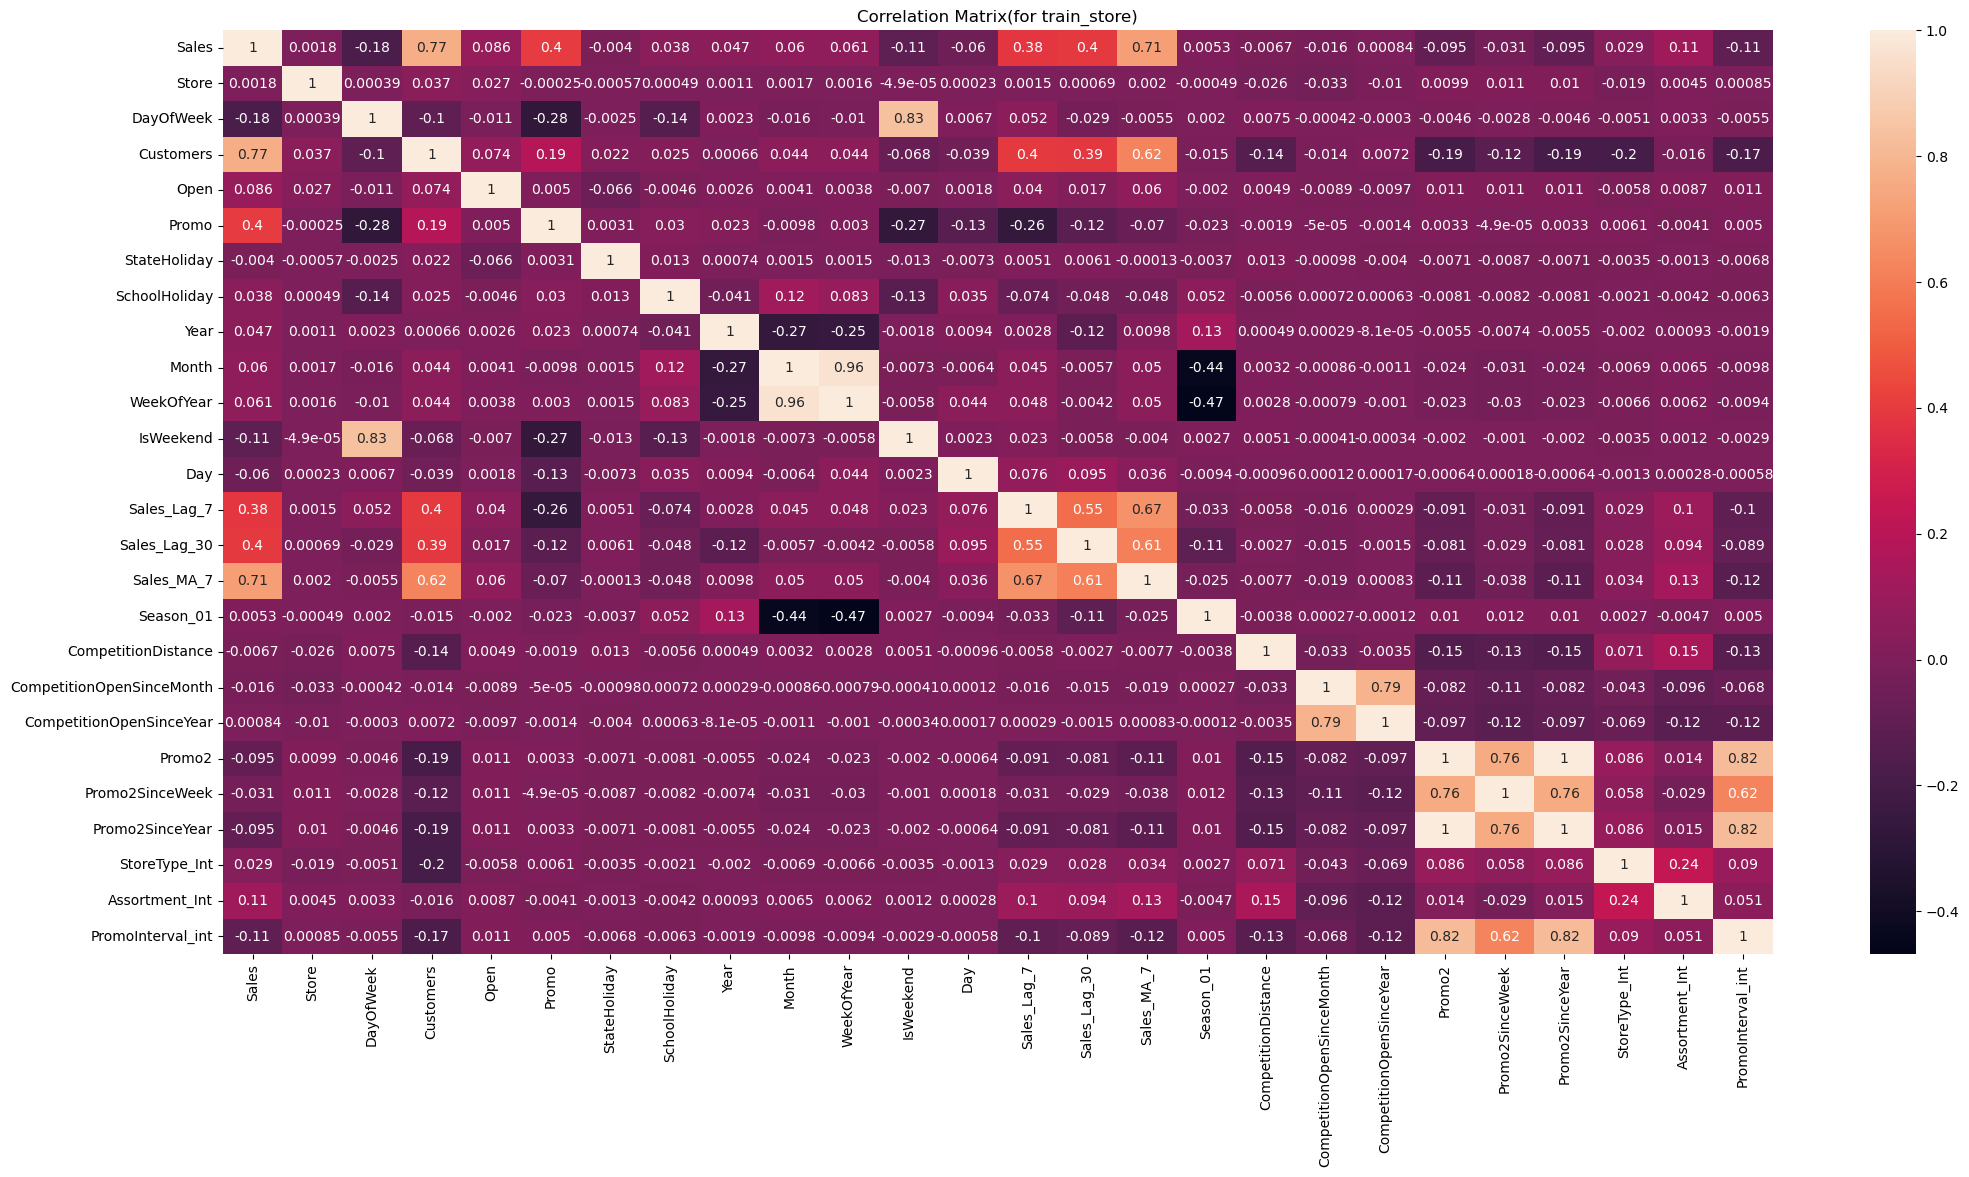

In [42]:
# Correlation 
feature = ['Sales', 'Store', 'DayOfWeek',  'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'WeekOfYear',
       'IsWeekend', 'Day', 'Sales_Lag_7', 'Sales_Lag_30', 'Sales_MA_7',
       'Season_01', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'StoreType_Int', 'Assortment_Int',
       'PromoInterval_int']

train_store_corr = train_store_corr[feature]

plt.figure(figsize=(25,12))
sns.heatmap(train_store_corr.corr(),annot=True)
plt.title("Correlation Matrix(for train_store)")

- **Recommendations based on high correlation:**<br>
  1. **Column 'Sales'** is correlated with **column 'Customers'** *(Correlation: 0.77)*. It should be kept for further analysis.
  2. **Column 'Sales'** is correlated with **column 'Sales_MA_7'** *(Correlation: 0.71)*. It should be kept for further analysis.
  3. **Column 'DayOfWeek'** is correlated with **column 'IsWeekend'** *(Correlation: 0.83)*. It should be kept for further analysis.
  4. **Column 'Month'** is correlated with **column 'WeekOfYear'** *(Correlation: 0.96)*. It should be dropped.
  5. **Column 'CompetitionOpenSinceMonth'** is correlated with **column 'CompetitionOpenSinceYear'** *(Correlation: 0.79)*. It should be kept for further analysis.
  6. **Column 'Promo2'** is correlated with **column 'Promo2SinceWeek'** *(Correlation: 0.76)*. It should be kept for further analysis.
  7. **Column 'Promo2'** is correlated with **column 'Promo2SinceYear'** *(Correlation: 1.00)*. It should be dropped.
  8. **Column 'Promo2'** is correlated with **column 'PromoInterval_int'** *(Correlation: 0.82)*. It should be kept for further analysis.
  9. **Column 'Promo2SinceWeek'** is correlated with **column 'Promo2SinceYear'** *(Correlation: 0.76)*. It should be kept for further analysis.
  10. **Column 'Promo2SinceYear'** is correlated with **column 'PromoInterval_int'** *(Correlation: 0.82)*. It should be kept for further analysis.<br><br>
                                                                                                                             
- **Action Taken**<br>
  1. column **'Customers'** *(Correlation: 0.77)*  will be drop
  2. Column **'DayOfWeek'** will be drop
  3. column **'WeekOfYear'** *(Correlation: 0.96)* will be drop
  4. column **'CompetitionOpenSinceYear'** will be drop 
  5. column **'Promo2SinceWeek'**, **'Promo2SinceYear'** and **'PromoInterval_int'** will be drop     
      

 

#### drop column based on high correlation

In [43]:
# drop column base on high correlation
columns = ['Customers', 'DayOfWeek',  'WeekOfYear', 'CompetitionOpenSinceYear','Promo2SinceWeek', 'Promo2SinceYear' ,'PromoInterval_int']
train_store.drop(columns = columns,inplace = True)

In [44]:
# drop column based on high correlation
columns = ['DayOfWeek',  'WeekOfYear', 'CompetitionOpenSinceYear','Promo2SinceWeek', 'Promo2SinceYear' ,'PromoInterval_int']
test_store.drop(columns = columns,inplace = True)

#### VIF : Checking for Multicollinearity

In [45]:

# drop column based on high correlation
columns = ['Sales','Customers', 'DayOfWeek',  'WeekOfYear', 'CompetitionOpenSinceYear','Promo2SinceWeek', 'Promo2SinceYear' ,'PromoInterval_int']
train_store_corr.drop(columns = columns,inplace = True)

X = train_store_corr
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                      Feature          VIF
0                       Store     3.986414
1                        Open  1010.220651
2                       Promo     2.142231
3                StateHoliday     1.006067
4               SchoolHoliday     1.308740
5                        Year  1033.363666
6                       Month     5.298218
7                   IsWeekend     1.680635
8                         Day     4.475843
9                 Sales_Lag_7    16.472572
10               Sales_Lag_30    11.220089
11                 Sales_MA_7    25.354462
12                  Season_01     4.175944
13        CompetitionDistance     1.584231
14  CompetitionOpenSinceMonth     2.365037
15                     Promo2     2.146338
16              StoreType_Int     3.890819
17             Assortment_Int     5.277031


Text(0.5, 1.0, 'Correlation Matrix(for train_store)')

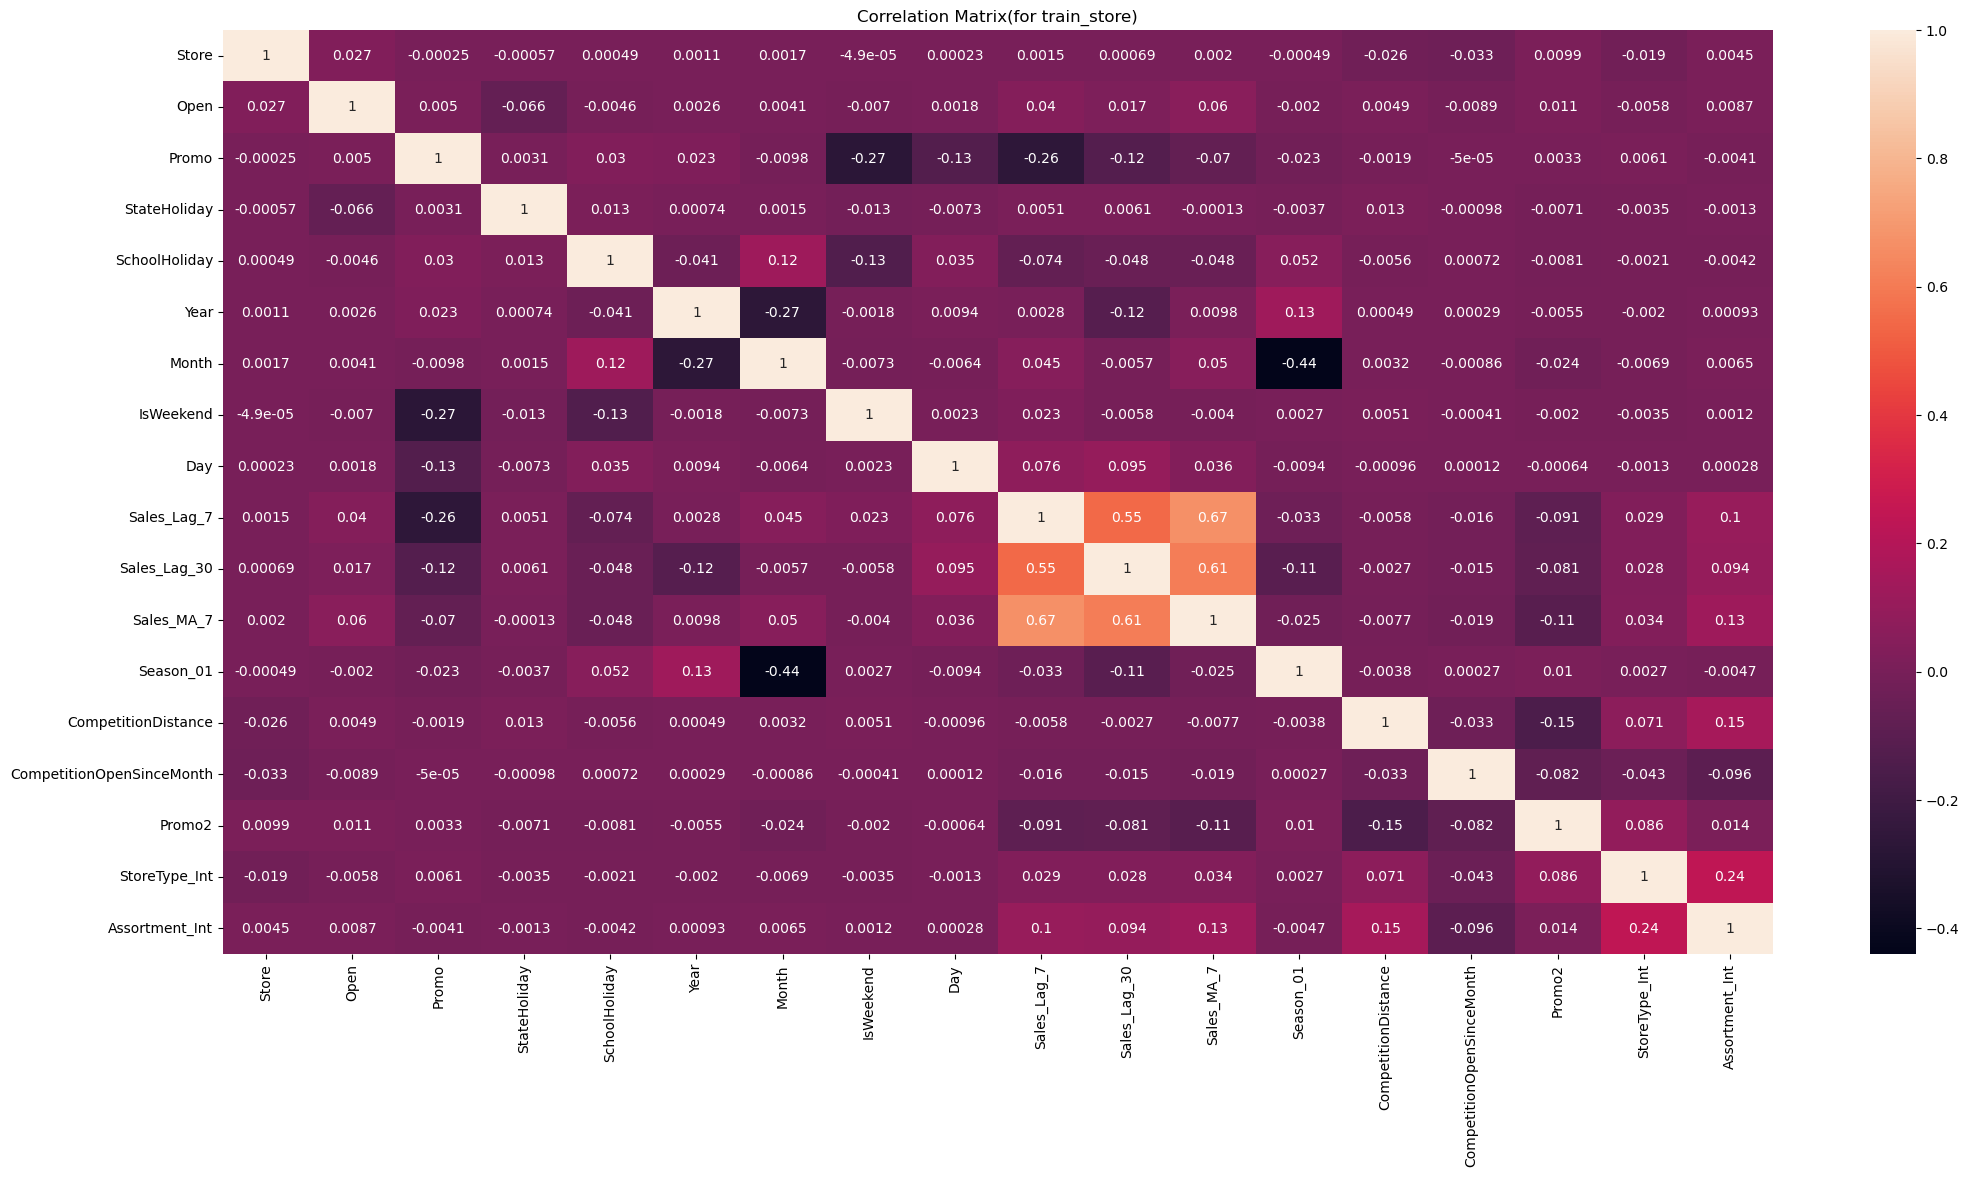

In [46]:
plt.figure(figsize=(25,12))
sns.heatmap(train_store_corr.corr(),annot=True)
plt.title("Correlation Matrix(for train_store)")

# Visualization

## Scatter Plot
#### Sales Over Customers

In [47]:
train_store.columns

Index(['Store', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'IsWeekend', 'Day', 'Sales_Lag_7',
       'Sales_Lag_30', 'Sales_MA_7', 'Season_01', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'Promo2', 'StoreType_Int',
       'Assortment_Int'],
      dtype='object')

Text(0, 0.5, 'Sales')

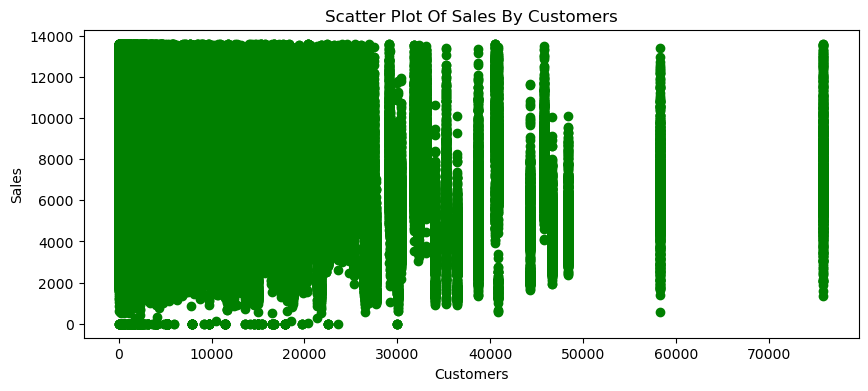

In [48]:
plt.figure(figsize = (10,4))
plt.title('Scatter Plot Of Sales By Customers')
plt.scatter(data = train_store ,x = 'CompetitionDistance' ,y = 'Sales',color = 'green')
plt.xlabel('Customers')
plt.ylabel('Sales')

## Line Plot
#### Sales Over Time

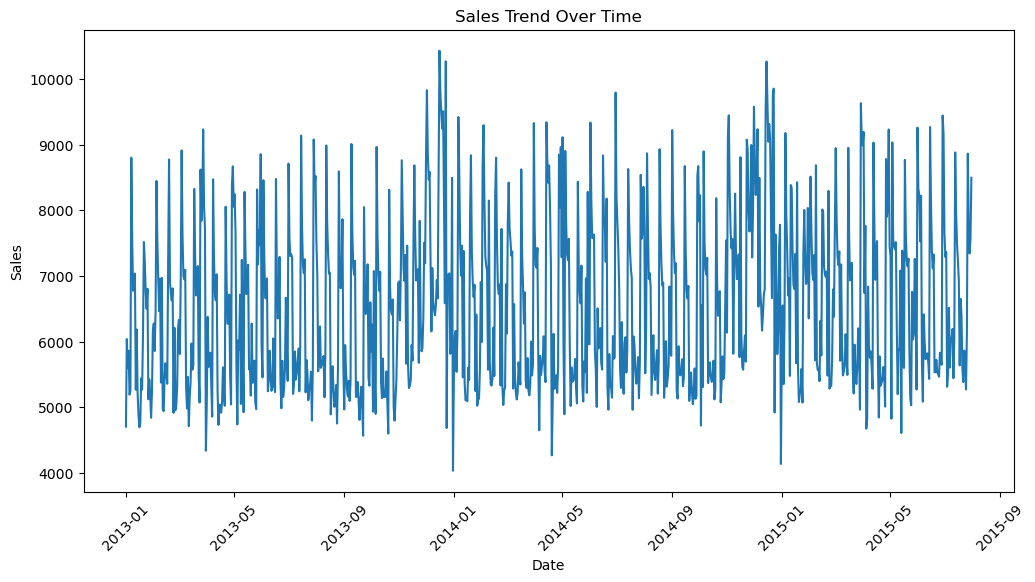

In [49]:
plt.figure(figsize = (12,6))
sns.lineplot(data = train_store,x = 'Date' , y ='Sales',ci = None )
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation = 45)
plt.show()

## Box Plot
#### Sales by Day of the Week

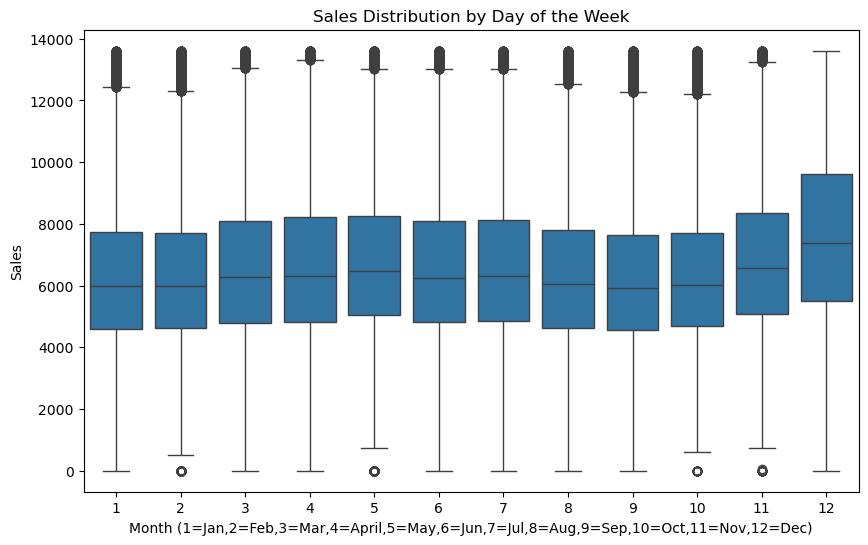

In [54]:
plt.figure(figsize = (10,6))
sns.boxplot(data = train_store,x = 'Month' , y ='Sales' )
plt.title('Sales Distribution by Day of the Week')
plt.xlabel('Month (1=Jan,2=Feb,3=Mar,4=April,5=May,6=Jun,7=Jul,8=Aug,9=Sep,10=Oct,11=Nov,12=Dec)')
plt.show()

## Histogram
#### Sales Distribution

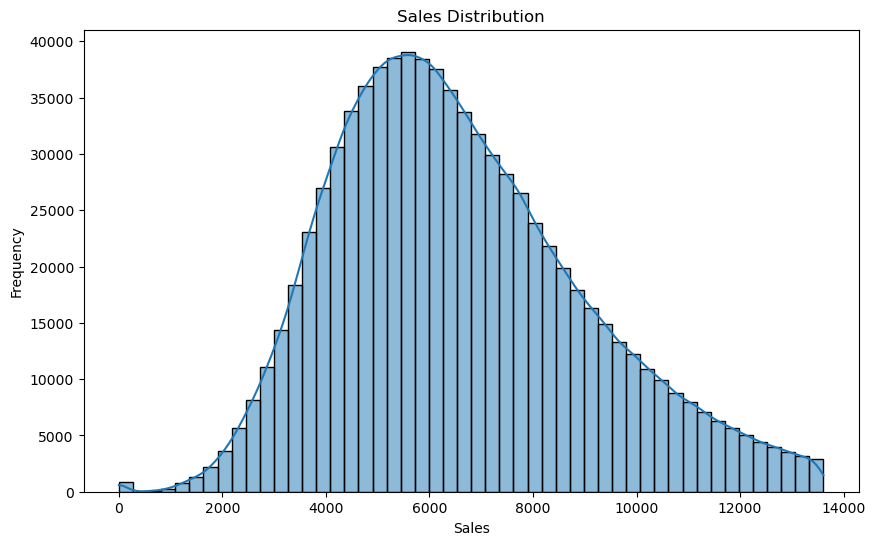

In [55]:
plt.figure(figsize = (10,6))
sns.histplot(train_store['Sales'] , bins = 50 , kde = True)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

## Bar Chart
#### Average Sales Per Store Type

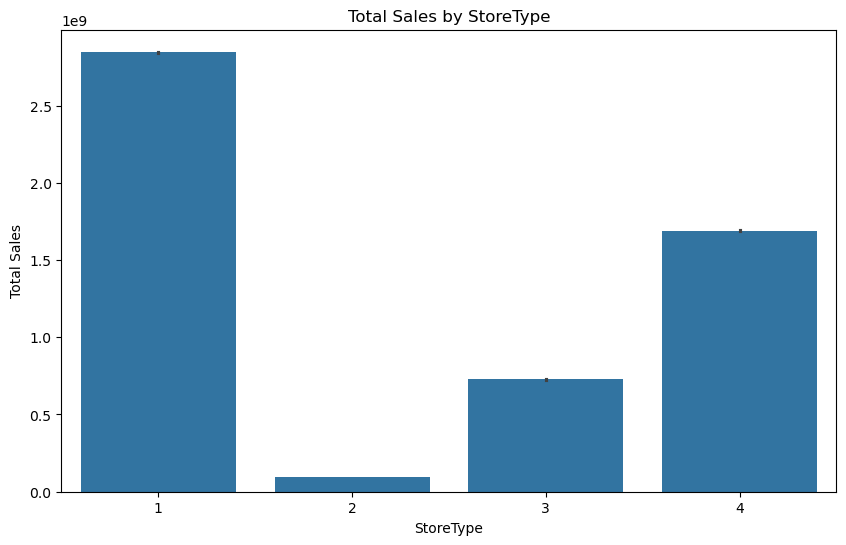

In [56]:
plt.figure(figsize = (10,6))
sns.barplot(data = train_store , x = 'StoreType_Int' , y = 'Sales' ,estimator = sum)
plt.title('Total Sales by StoreType')
plt.xlabel('StoreType')
plt.ylabel('Total Sales')
plt.show()

## Bar Chart
#### Average Sales by Assortment

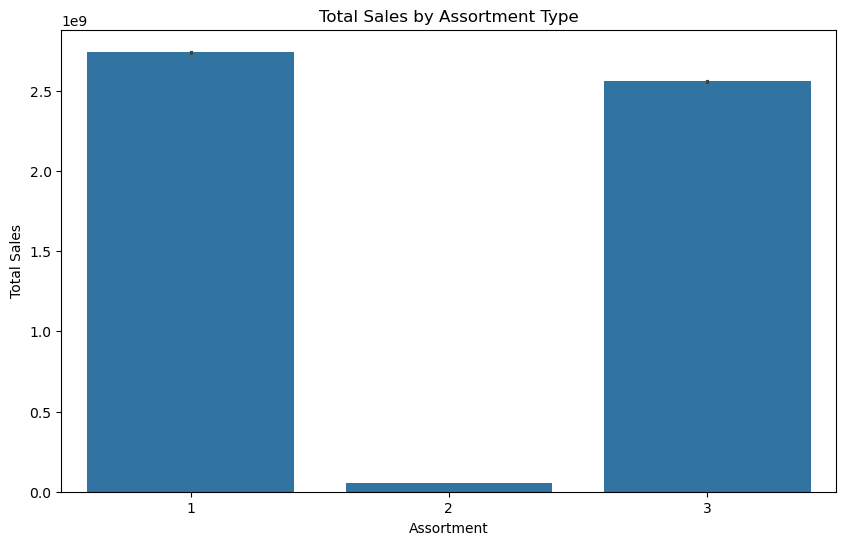

In [57]:
plt.figure(figsize = (10,6))
sns.barplot(data = train_store , x = 'Assortment_Int' , y = 'Sales' ,estimator = sum)
plt.title('Total Sales by Assortment Type')
plt.xlabel('Assortment')
plt.ylabel('Total Sales')
plt.show()

## Correlation Heatmap
#### Sales versus Other Featrues

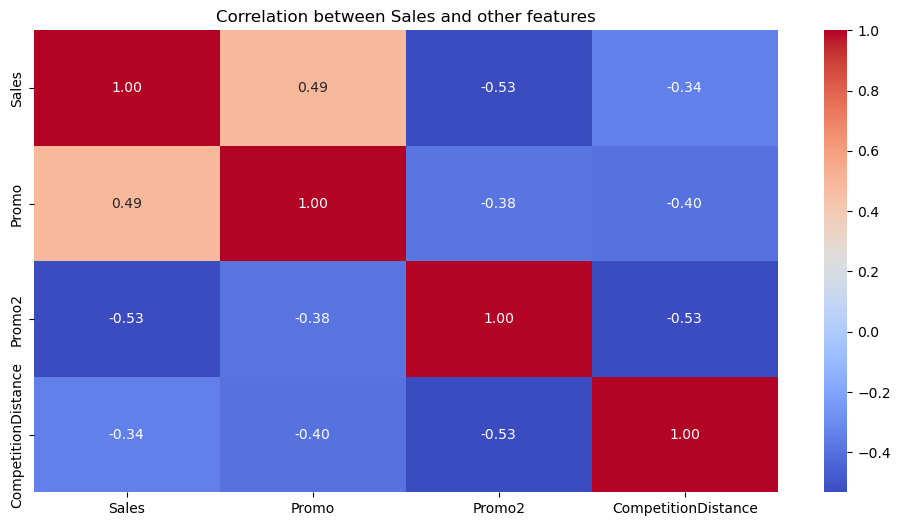

In [59]:
plt.figure(figsize = (12,6))
corr_matrix = train_store[['Sales','Promo','Promo2','CompetitionDistance']].corr()
sns.heatmap(corr_matrix.corr(),annot=True,cmap = 'coolwarm',fmt = '.2f')
plt.title("Correlation between Sales and other features")
plt.show()

In [60]:
train_store.columns

Index(['Store', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'IsWeekend', 'Day', 'Sales_Lag_7',
       'Sales_Lag_30', 'Sales_MA_7', 'Season_01', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'Promo2', 'StoreType_Int',
       'Assortment_Int'],
      dtype='object')

In [61]:
test_store.columns

Index(['Id', 'Store', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'Year', 'Month', 'IsWeekend', 'Day', 'Sales_Lag_7', 'Sales_Lag_30',
       'Sales_MA_7', 'Season_01', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'Promo2', 'StoreType_Int',
       'Assortment_Int'],
      dtype='object')

#### rename columns

In [62]:
# rename column
train_store.rename(columns ={'StoreType_Int' : 'StoreType', 'Assortment_Int' : 'Assortment','Season_01' : 'Season','Open' : 'Store_Open'},inplace =True)
test_store.rename(columns ={'StoreType_Int' : 'StoreType', 'Assortment_Int' : 'Assortment','Season_01' : 'Season','Open' : 'Store_Open'},inplace =True)

In [63]:
train_store.columns,test_store.columns

(Index(['Store', 'Date', 'Sales', 'Store_Open', 'Promo', 'StateHoliday',
        'SchoolHoliday', 'Year', 'Month', 'IsWeekend', 'Day', 'Sales_Lag_7',
        'Sales_Lag_30', 'Sales_MA_7', 'Season', 'CompetitionDistance',
        'CompetitionOpenSinceMonth', 'Promo2', 'StoreType', 'Assortment'],
       dtype='object'),
 Index(['Id', 'Store', 'Date', 'Store_Open', 'Promo', 'StateHoliday',
        'SchoolHoliday', 'Year', 'Month', 'IsWeekend', 'Day', 'Sales_Lag_7',
        'Sales_Lag_30', 'Sales_MA_7', 'Season', 'CompetitionDistance',
        'CompetitionOpenSinceMonth', 'Promo2', 'StoreType', 'Assortment'],
       dtype='object'))

In [64]:
# Select Features & Target Variable
features = ['Store', 'Store_Open', 'Promo', 'StateHoliday',
        'SchoolHoliday', 'Year', 'Month', 'IsWeekend', 'Day', 'Sales_Lag_7',
        'Sales_Lag_30', 'Sales_MA_7', 'Season', 'CompetitionDistance',
        'CompetitionOpenSinceMonth', 'Promo2', 'StoreType', 'Assortment']
X = train_store[features]
Y = train_store["Sales"]



#### Validation Dataset

In [65]:
# Split-out validation dataset

validation_size = 0.20
seed = 42
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
test_size=validation_size, random_state=seed,shuffle =True)

#### Test options and evaluation metric

In [66]:
# Test options and evaluation metric
num_folds = 5
scoring = 'r2'

In [67]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',
LinearRegression())])))
pipelines.append(('ScaledLGBMR', Pipeline([('Scaler', StandardScaler()),('LGBMR',
LGBMRegressor())]))) 
pipelines.append(('ScaledXGBR', Pipeline([('Scaler', StandardScaler()),('XGBR',
XGBRegressor(random_state=seed))]))) 
pipelines.append(('ScaledCATR', Pipeline([('Scaler', StandardScaler()),('CATR',
CatBoostRegressor(verbose = False))])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.721725 (0.000938)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 521151, number of used features: 18
[LightGBM] [Info] Start training from score 6571.734146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 521151, number of used features: 18
[LightGBM] [Info] Start training from score 6577.640333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067521 seconds.
You can set `force_row_wise=true` to remove th

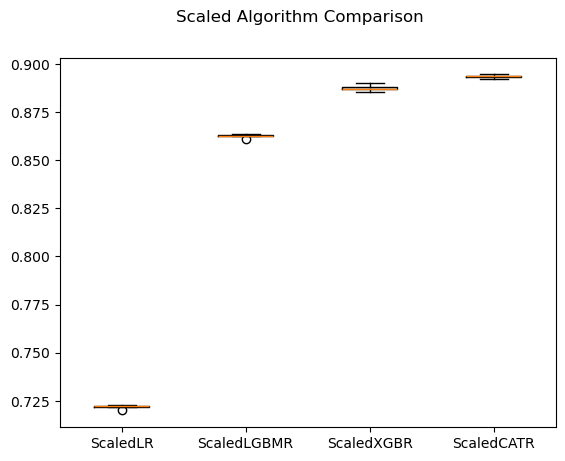

In [70]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()


#### Improve Results With Tuning

In [71]:
# Define hyperparameter distributions
param_dist = {
    'n_estimators' : [100 , 200 , 300 , 500 , 700 , 1000],
    'max_depth' : [3 , 5 , 7 , 9 , 11],
    'learning_rste' : [0.1 , 0.05 , 0.01 , 0.001],
    'subsample' : [0.6 , 0.8 , 1.0],
    'colsample_bytree' : [0.6 , 0.8 , 1.0],
    'gamma' : [0 , 0.1 , 0.2]
}
# Configure XGBoost with efficient settings
model = XGBRegressor (tree_method = 'hist', # optimized for large dataset
                      n_jobs = -1 , # use all CPU cores
                      random_state = seed)
kfold = KFold(n_splits = num_folds , random_state = seed ,shuffle= True)
#RandomizedCV with reduced iterations
grid = RandomizedSearchCV(
    estimator = model ,
    param_distributions = param_dist ,
    n_iter = 5 , # Total parameter combination
    scoring = scoring ,
    cv = kfold,
    verbose = 3 ,
    n_jobs = -1 # use all CPU cores
)

grid_result = grid.fit(X_train , Y_train)
# Output results
print(f"Best Score : {grid_result.best_score_:.4f}")
print(f"Best Params : {grid_result.best_params_}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score : 0.9187
Best Params : {'subsample': 0.6, 'n_estimators': 700, 'max_depth': 7, 'learning_rste': 0.001, 'gamma': 0.1, 'colsample_bytree': 1.0}


In [77]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = XGBRegressor(subsample = 0.6, n_estimators = 700, max_depth = 7, learning_rste = 0.01, gamma = 0.1, colsample_bytree = 1.0,random_state = seed)
model.fit(rescaledX, Y_train)
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(r2_score(Y_validation, predictions))

0.9217497706413269


In [78]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = XGBRegressor(subsample = 0.6, n_estimators = 700, max_depth = 7, learning_rste = 0.01, gamma = 0.1, colsample_bytree = 1.0,random_state = seed)
model.fit(rescaledX, Y_train)
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(root_mean_squared_error(Y_validation, predictions))

681.5883362499615


In [79]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = XGBRegressor(subsample = 0.6, n_estimators = 700, max_depth = 7, learning_rste = 0.01, gamma = 0.1, colsample_bytree = 1.0,random_state = seed)
model.fit(rescaledX, Y_train)
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(mean_absolute_error(Y_validation, predictions))

492.2393795282809


In [80]:
feature = test_store[['Store', 'Store_Open', 'Promo', 'StateHoliday',
        'SchoolHoliday', 'Year', 'Month', 'IsWeekend', 'Day', 'Sales_Lag_7',
        'Sales_Lag_30', 'Sales_MA_7', 'Season', 'CompetitionDistance',
        'CompetitionOpenSinceMonth', 'Promo2', 'StoreType', 'Assortment']]

test_store['Predicted_XGBoost_Sales']= model.predict(feature)

In [81]:
test_store[['Id','Date','Predicted_XGBoost_Sales']].sort_values(by ="Date").reset_index(drop =True).to_csv('Predicted_XGBoost_Sales.csv')